In [2]:
import tensorflow as tf
from vit_keras import vit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np


In [3]:
DATASET_PATH = "Dataset/images"

In [4]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=30,     
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,         
    horizontal_flip=True,
    fill_mode="nearest" 
)

In [68]:
train_generator = data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

validation_generator = data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 7207 images belonging to 30 classes.
Found 1788 images belonging to 30 classes.


In [69]:
vit_model = vit.vit_b16(   
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

/home/janha30372/.conda/envs/janha30372_environment/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [70]:
for layer in vit_model.layers[-20:]:
    layer.trainable = True

In [71]:
inputs = tf.keras.Input(shape=(224, 224, 3))
vit_output = vit_model(inputs)

In [72]:
x = tf.keras.layers.Flatten()(vit_output)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.5)(x)  
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [73]:
optimizer = Adam(learning_rate=3e-5, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [74]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=3,  
    min_lr=1e-6,  
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  
    min_delta=0.002,  
    restore_best_weights=True
)


In [75]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]  
)


Epoch 1/50
225/225 [==============================] - 765s 3s/step - loss: 3.3152 - accuracy: 0.1483 - val_loss: 1.8427 - val_accuracy: 0.6460 - lr: 3.0000e-05
Epoch 2/50
225/225 [==============================] - 740s 3s/step - loss: 1.9552 - accuracy: 0.4962 - val_loss: 0.9300 - val_accuracy: 0.7830 - lr: 3.0000e-05
Epoch 3/50
225/225 [==============================] - 735s 3s/step - loss: 1.2834 - accuracy: 0.6793 - val_loss: 0.6601 - val_accuracy: 0.8562 - lr: 3.0000e-05
Epoch 4/50
225/225 [==============================] - 735s 3s/step - loss: 1.0006 - accuracy: 0.7647 - val_loss: 0.5409 - val_accuracy: 0.8881 - lr: 3.0000e-05
Epoch 5/50
225/225 [==============================] - 732s 3s/step - loss: 0.8113 - accuracy: 0.8167 - val_loss: 0.5433 - val_accuracy: 0.8920 - lr: 3.0000e-05
Epoch 6/50
225/225 [==============================] - 729s 3s/step - loss: 0.6956 - accuracy: 0.8502 - val_loss: 0.4817 - val_accuracy: 0.9193 - lr: 3.0000e-05
Epoch 7/50
225/225 [====================

In [76]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

class_labels = list(train_generator.class_indices.keys())

for _ in range(len(validation_generator)):
    x_batch, y_batch = validation_generator.next()
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))  
    y_pred.extend(np.argmax(preds, axis=1))  


print(classification_report(y_true, y_pred, target_names=class_labels))

1/1 [==============================] - 2s 2s/step
                       precision    recall  f1-score   support

         Ajanta Caves       0.81      0.76      0.78        62
            Amer Fort       1.00      0.93      0.96        59
Brihadeeswarar Temple       0.81      0.78      0.79        59
            Charminar       0.97      1.00      0.98        59
          City Palace       0.88      0.83      0.85        60
      Elephanta Caves       0.93      0.97      0.95        59
         Ellora Caves       0.75      0.78      0.76        60
       Fatehpur Sikri       0.98      0.98      0.98        59
     Gateway of India       1.00      1.00      1.00        59
        Golconda Fort       0.98      0.95      0.97        60
           Hawa Mahal       0.97      0.98      0.97        59
       Humayun's Tomb       0.98      1.00      0.99        59
       Jaisalmer Fort       0.97      1.00      0.98        59
          Jama Masjid       0.89      0.93      0.91        60
    

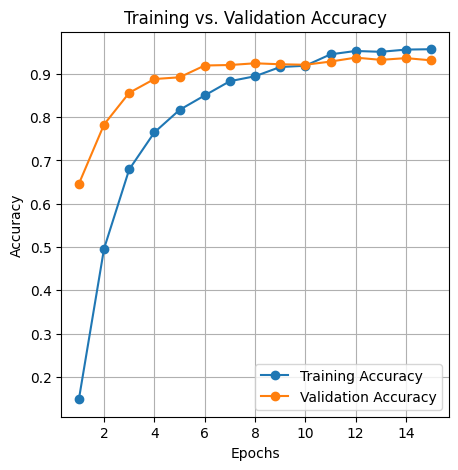

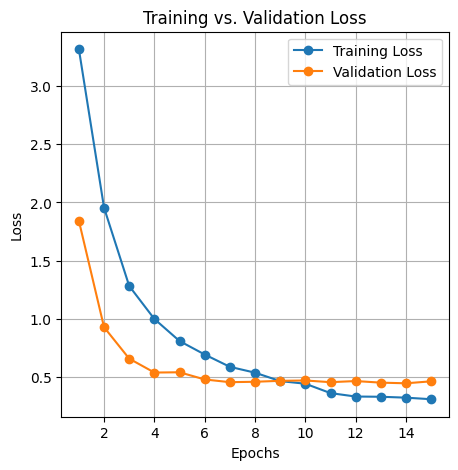

In [77]:
import matplotlib.pyplot as plt


history_dict = history.history  
epochs = range(1, len(history_dict["accuracy"]) + 1)  


plt.figure(figsize=(5, 5))
plt.plot(epochs, history_dict["accuracy"], marker="o", label="Training Accuracy") 
plt.plot(epochs, history_dict["val_accuracy"], marker="o", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.grid(True)
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(epochs, history_dict["loss"], marker="o", label="Training Loss")  
plt.plot(epochs, history_dict["val_loss"], marker="o", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.grid(True)
plt.show()


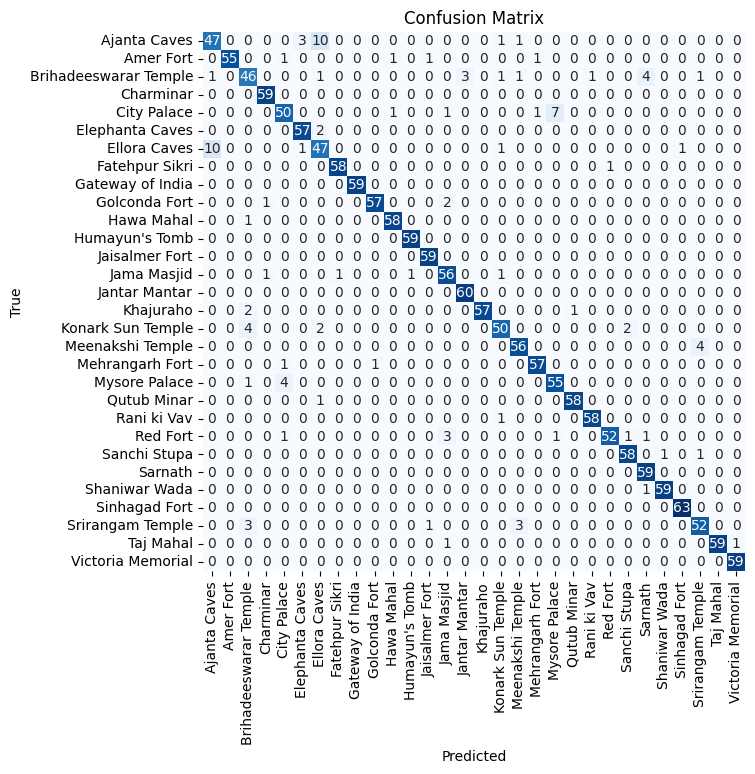

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 7))


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



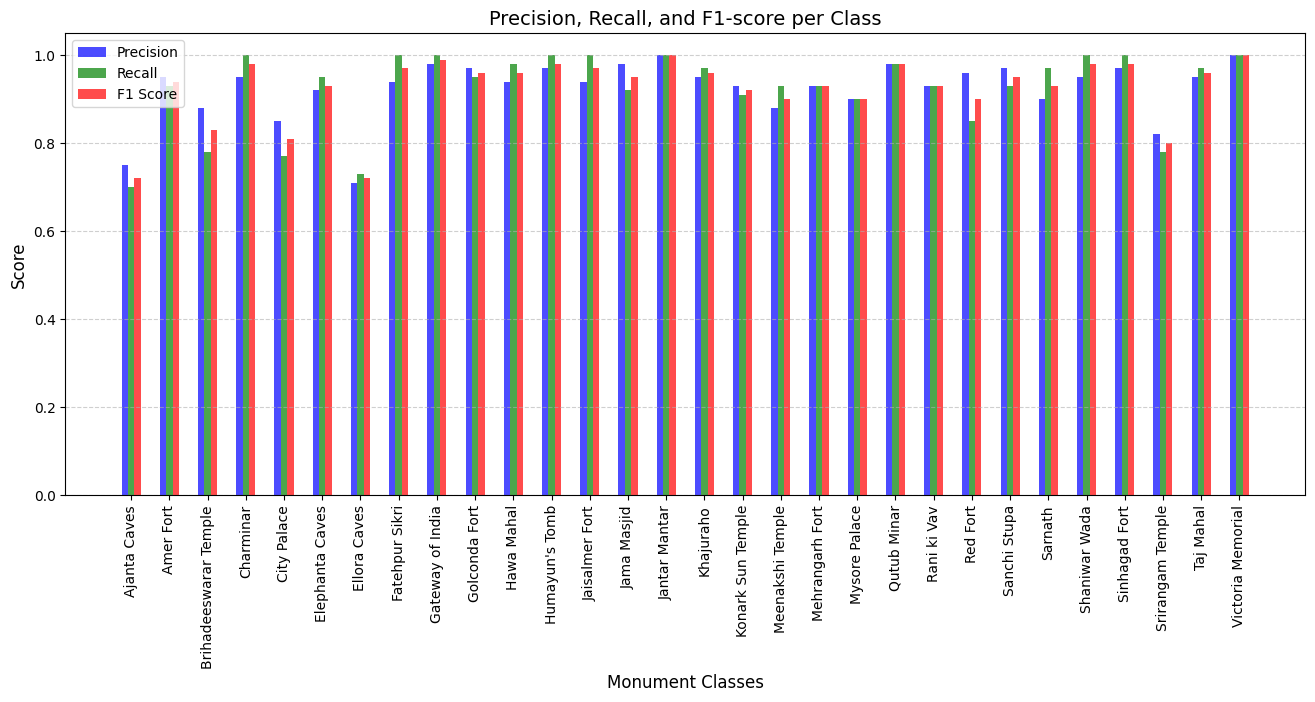

In [59]:
import numpy as np
import matplotlib.pyplot as plt


monuments = [
    "Ajanta Caves", "Amer Fort", "Brihadeeswarar Temple", "Charminar", "City Palace",
    "Elephanta Caves", "Ellora Caves", "Fatehpur Sikri", "Gateway of India", "Golconda Fort",
    "Hawa Mahal", "Humayun's Tomb", "Jaisalmer Fort", "Jama Masjid", "Jantar Mantar",
    "Khajuraho", "Konark Sun Temple", "Meenakshi Temple", "Mehrangarh Fort", "Mysore Palace",
    "Qutub Minar", "Rani ki Vav", "Red Fort", "Sanchi Stupa", "Sarnath",
    "Shaniwar Wada", "Sinhagad Fort", "Srirangam Temple", "Taj Mahal", "Victoria Memorial"
]


precision = [0.75, 0.95, 0.88, 0.95, 0.85, 0.92, 0.71, 0.94, 0.98, 0.97, 
             0.94, 0.97, 0.94, 0.98, 1.00, 0.95, 0.93, 0.88, 0.93, 0.90, 
             0.98, 0.93, 0.96, 0.97, 0.90, 0.95, 0.97, 0.82, 0.95, 1.00]

recall = [0.70, 0.93, 0.78, 1.00, 0.77, 0.95, 0.73, 1.00, 1.00, 0.95, 
          0.98, 1.00, 1.00, 0.92, 1.00, 0.97, 0.91, 0.93, 0.93, 0.90, 
          0.98, 0.93, 0.85, 0.93, 0.97, 1.00, 1.00, 0.78, 0.97, 1.00]

f1_score = [0.72, 0.94, 0.83, 0.98, 0.81, 0.93, 0.72, 0.97, 0.99, 0.96, 
            0.96, 0.98, 0.97, 0.95, 1.00, 0.96, 0.92, 0.90, 0.93, 0.90, 
            0.98, 0.93, 0.90, 0.95, 0.93, 0.98, 0.98, 0.80, 0.96, 1.00]

x = np.arange(len(monuments)) * 1.8 
width = 0.3 


plt.figure(figsize=(16, 6))
plt.bar(x - width, precision, width, label="Precision", color='b', alpha=0.7)
plt.bar(x, recall, width, label="Recall", color='g', alpha=0.7)
plt.bar(x + width, f1_score, width, label="F1 Score", color='r', alpha=0.7)


plt.xlabel("Monument Classes", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision, Recall, and F1-score per Class", fontsize=14)
plt.xticks(ticks=x, labels=monuments, rotation=90, fontsize=10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()



1/1 [==============================] - 0s 164ms/step


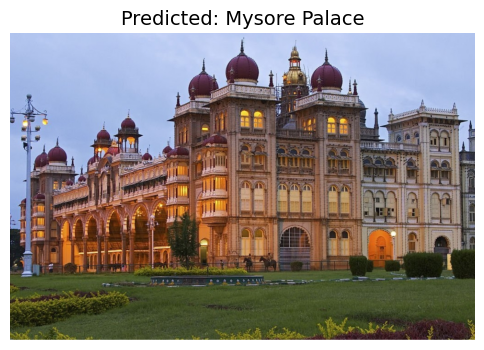

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_monument(img_path, model, class_labels):
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0 

    # Predict
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=1)[0]  
    predicted_label = class_labels[predicted_class]  

    
    original_img = cv2.imread(img_path)  
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  

   
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img)  
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", fontsize=14, color="black")
    plt.show()

    return predicted_label


img_path = "Dataset/images/Mysore Palace/Image_4.jpg" 
predicted_monument = predict_monument(img_path, model, class_labels)
